In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind, norm, ttest_rel


file_path = '../data/sirs_demo_abc_clean'
df = pd.read_pickle(file_path)

In [2]:
df['Date Reviewed'] = pd.to_datetime(df['Date Reviewed'], errors='coerce')
df['Date Enrolled in START'] = pd.to_datetime(df['Date Enrolled in START'])

df = df.dropna(subset=['Date Reviewed'])

df['sum_abc'] = df[['Irritability/Agitation', 'Lethargy/Social Withdrawal', 'Stereotypic Behavior',
                   'Hyperactivity/Noncompliance', 'Inappropriate Speech']].sum(axis=1)

# Define COVID-19 onset date
covid_onset_date = pd.Timestamp('2020-03-13')
# List of races to analyze
races = df['race_clean'].unique()
races

array(['Asian/Pacific Islander', 'White', 'Hispanic/Latinx',
       'American Indian or Alaska Native', 'Black/African American',
       'Other/Unknown'], dtype=object)

**Functions**

In [3]:
# Function that analyzes the differences by a specified race
def analyze_by_race(race):    
    # Further separate into Intake and Re-evaluation for both periods
    before_covid_intake_race = before_covid_intake[before_covid_intake['race_clean'] == race]
    before_covid_reevaluation_race = before_covid_reevaluation[before_covid_reevaluation['race_clean'] == race]

    after_covid_intake_race = after_covid_intake[after_covid_intake['race_clean'] == race]
    after_covid_reevaluation_race = after_covid_reevaluation[after_covid_reevaluation['race_clean'] == race]

    # Calculate  mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake_race.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation_race.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake_race.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation_race.mean(numeric_only=True)

    # Combine the means into dfs for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Percent Change (Before COVID)'] = (before_covid_comparison['Re-evaluation Mean (Before COVID)'] - before_covid_comparison['Intake Mean (Before COVID)']) / before_covid_comparison['Intake Mean (Before COVID)'] * 100

    after_covid_comparison = pd.DataFrame({
        'Intake Mean (After COVID)': after_covid_intake_means,
        'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    })
    after_covid_comparison['Percent Change (After COVID)'] = (after_covid_comparison['Re-evaluation Mean (After COVID)'] - after_covid_comparison['Intake Mean (After COVID)']) / after_covid_comparison['Intake Mean (After COVID)'] * 100

    # Calculate change in percent change
    change_in_difference = before_covid_comparison['Percent Change (Before COVID)'] - after_covid_comparison['Percent Change (After COVID)']
    change_in_difference.name = 'Change in Percent Change'

    return change_in_difference


In [4]:
# analyze differences by race and calculate confidence intervals - uses the analyze_by_race() function
def analyze_and_calculate_ci_by_race(race):
    change_in_difference = analyze_by_race(race)

    sum_change_in_difference = change_in_difference.sum()

    std_err = stats.sem(change_in_difference)
    
    test_stat = sum_change_in_difference / std_err
    
    p_value = 2 * (1 - stats.t.cdf(abs(test_stat), df=len(change_in_difference) - 1))

    z_score = stats.norm.ppf(1 - p_value / 2)

    margin_of_error = z_score * std_err

    return sum_change_in_difference, margin_of_error

# analyze differences by race and calculate p-values
def analyze_and_calculate_p_value_by_race(race):
    change_in_difference = analyze_by_race(race)
    
    sum_change_in_difference = change_in_difference.sum()

    std_err = stats.sem(change_in_difference)
    
    test_stat = sum_change_in_difference / std_err
    
    p_value = 2 * (1 - stats.t.cdf(abs(test_stat), df=len(change_in_difference) - 1))

    return sum_change_in_difference, p_value


In [5]:
def diff_means(race, column):
    # Separate data into before and after COVID-19 windows
    before_covid_data_race = before_covid_data[before_covid_data['race_clean'] == race]
    after_covid_data_race = after_covid_data[after_covid_data['race_clean'] == race]

    # Means
    mean_before = before_covid_data_race[column].mean()
    mean_after = after_covid_data_race[column].mean()

    # Dfference in means
    mean_diff = mean_after - mean_before

    # run t-test
    t_stat, p_value = ttest_ind(before_covid_data_race[column].dropna(), after_covid_data_race[column].dropna())

    # Confidence interval
    n1 = before_covid_data_race[column].dropna().shape[0]
    n2 = after_covid_data_race[column].dropna().shape[0]
    std_before = before_covid_data_race[column].dropna().std()
    std_after = after_covid_data_race[column].dropna().std()
    se = np.sqrt(std_before**2 / n1 + std_after**2 / n2)
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    ci_lower = mean_diff - z * se
    ci_upper = mean_diff + z * se

    results = pd.DataFrame({
        'mean_before': [mean_before],
        'mean_after': [mean_after],
        'mean_diff': [mean_diff],
        't_stat': [t_stat],
        'p_value': [p_value],
        'ci_lower': [ci_lower],
        'ci_upper': [ci_upper]
    }, index=[column])

    return results


**Cleaning our data**

In [6]:
before_covid_data = df[df['Date Reviewed'] < covid_onset_date]
after_covid_data = df[df['Date Reviewed'] >= covid_onset_date]

before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

In [7]:
# Calculate observations
# This code is to create a descriptive analysis table for our data
pre_observations = before_covid_data.shape[0]
pre_intake_observations = before_covid_intake.shape[0]
pre_reeval_observations = before_covid_reevaluation.shape[0]

post_observations = after_covid_data.shape[0]
post_intake_observations = after_covid_intake.shape[0]
post_reeval_observations = after_covid_reevaluation.shape[0]

# Get race counts
race_counts_pre_intake = before_covid_intake['race_clean'].value_counts()
race_counts_pre_reevaluation = before_covid_reevaluation['race_clean'].value_counts()
race_counts_post_intake = after_covid_intake['race_clean'].value_counts()
race_counts_post_reevaluation = after_covid_reevaluation['race_clean'].value_counts()

descriptive_analysis = pd.DataFrame({
    'Testing Window': ['Pre-COVID', 'Post-COVID'],
    'Intake': [pre_intake_observations, post_intake_observations],
    'Re-evaluation' : [pre_reeval_observations, post_reeval_observations],
    'Total': [pre_observations, post_observations]
})

# Prettify the table
styled_total = descriptive_analysis.style.hide(axis='index').set_caption("Pre- and Post-COVID Observations")\
    .format(na_rep='-', precision=0)\
    .set_table_styles(
        [{'selector': 'caption',
          'props': [('color', 'black'),
                    ('font-size', '16px'),
                    ('text-align', 'center'),
                    ('font-weight', 'bold')]},
         {'selector': 'th',
          'props': [('border', '1px solid black'),
                    ('background-color', '#f7f7f7'),
                    ('padding', '5px')]},
         {'selector': 'td',
          'props': [('border', '1px solid black'),
                    ('padding', '5px')]}]
    )

styled_total
styled_total.to_excel('../output/Pre- and Post-COVID Observations.xlsx', index=False)

In [8]:
styled_total

Testing Window,Intake,Re-evaluation,Total
Pre-COVID,4069,8795,12941
Post-COVID,907,5561,6484


In [9]:
# This code is to make a descriptive analysis table based on race
# Convert race counts to DataFrames and add to the descriptive analysis
race_counts_pre_intake_df = race_counts_pre_intake.reset_index()
race_counts_pre_intake_df.columns = ['Race', 'Pre-COVID Intake']

race_counts_pre_reevaluation_df = race_counts_pre_reevaluation.reset_index()
race_counts_pre_reevaluation_df.columns = ['Race', 'Pre-COVID Re-evaluation']

race_counts_post_intake_df = race_counts_post_intake.reset_index()
race_counts_post_intake_df.columns = ['Race', 'Post-COVID Intake']

race_counts_post_reevaluation_df = race_counts_post_reevaluation.reset_index()
race_counts_post_reevaluation_df.columns = ['Race', 'Post-COVID Re-evaluation']

# Merge all race counts into a single DataFrame
race_counts_merged = pd.merge(race_counts_pre_intake_df, race_counts_pre_reevaluation_df, on='Race', how='outer')
race_counts_merged = pd.merge(race_counts_merged, race_counts_post_intake_df, on='Race', how='outer')
race_counts_merged = pd.merge(race_counts_merged, race_counts_post_reevaluation_df, on='Race', how='outer')


race_counts_merged.fillna(0, inplace=True)

race_counts_merged = race_counts_merged[['Race', 'Pre-COVID Intake', 'Pre-COVID Re-evaluation', 'Post-COVID Intake', 'Post-COVID Re-evaluation']]



# Prettify the table
styled_table = race_counts_merged.style.hide(axis="index").set_caption("Count of Pre- and Post-COVID Observations by Race")\
    .format(na_rep='-', precision=0)\
    .set_table_styles(
        [{'selector': 'caption',
          'props': [('color', 'black'),
                    ('font-size', '16px'),
                    ('text-align', 'center'),
                    ('font-weight', 'bold')]},
         {'selector': 'th',
          'props': [('border', '1px solid black'),
                    ('background-color', '#f7f7f7'),
                    ('padding', '5px')]},
         {'selector': 'td',
          'props': [('border', '1px solid black'),
                    ('padding', '5px')]}]
    )

styled_table.to_excel('../output/Pre_and_Post_COVID_Observations_Race.xlsx', index=False)

In [10]:
styled_table

Race,Pre-COVID Intake,Pre-COVID Re-evaluation,Post-COVID Intake,Post-COVID Re-evaluation
White,2492,5610,586,3444
Black/African American,857,2005,159,1092
Other/Unknown,360,546,83,467
Hispanic/Latinx,200,353,43,336
Asian/Pacific Islander,139,242,30,183
American Indian or Alaska Native,21,39,6,39


**2. Demographic Disparities Analysis**

**2a. Disparities in ABC Scores**

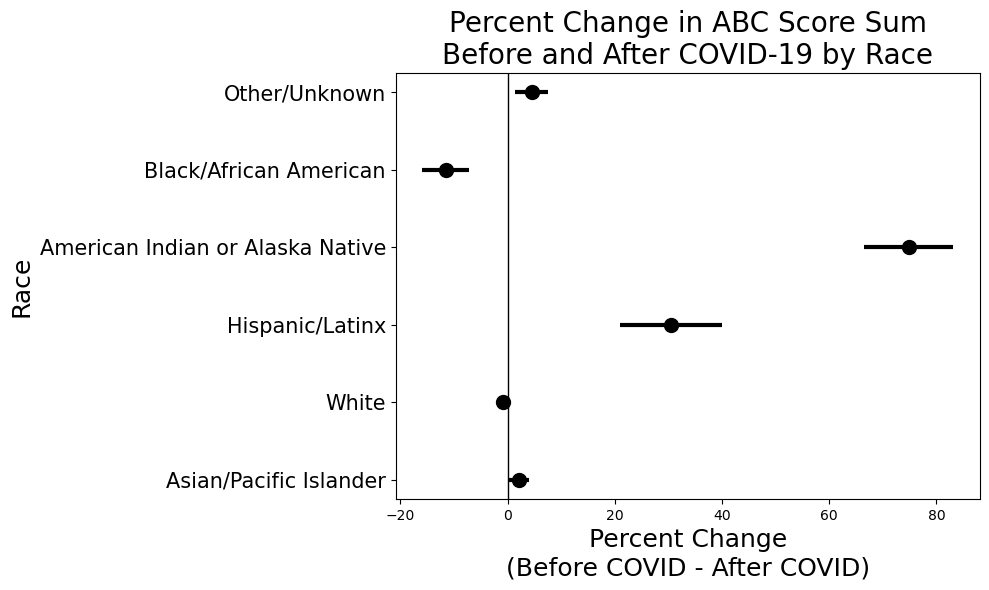

In [11]:
sum_changes_ci_by_race = {race: analyze_and_calculate_ci_by_race(race) for race in races}

sum_changes_df = pd.DataFrame(sum_changes_ci_by_race, index=['Sum of Changes', 'CI']).T

# Adjust the scale of the objects in the plot
line_width = 3  
marker_size = 10  
label_font_size = 18
title_font_size = 20
tick_font_size = 15

plt.figure(figsize=(10, 6))

for i, race in enumerate(sum_changes_df.index):
    plt.errorbar(sum_changes_df.loc[race, 'Sum of Changes'], i, xerr=sum_changes_df.loc[race, 'CI'], fmt='o', color='black', capsize=0, linewidth=line_width, markersize=marker_size)

plt.axvline(0, color='black', linewidth=1, linestyle='-')

plt.xlabel('Percent Change\n(Before COVID - After COVID)', fontsize=label_font_size)
plt.ylabel('Race', fontsize=label_font_size)
plt.title('Percent Change in ABC Score Sum\nBefore and After COVID-19 by Race', fontsize=title_font_size)
plt.yticks(range(len(sum_changes_df.index)), sum_changes_df.index, fontsize=tick_font_size)

plt.tight_layout()

plt.savefig('../output/change_in_abc_score_by_race.png')

plt.show()

In [12]:
sum_changes_df.to_excel('../output/Percent_Change_in_ABC_score.xlsx', index=False)

In [13]:
numeric_columns = df.select_dtypes(include=['number']).columns


sum_changes_p_values_by_race = {race: analyze_and_calculate_p_value_by_race(race) for race in races}

sum_changes_df = pd.DataFrame(sum_changes_p_values_by_race, index=['Percent Change', 'p-value']).T

sum_changes_df['Statistical Significance'] = sum_changes_df['p-value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')

sum_changes_df

,Percent Change,p-value,Statistical Significance
Asian/Pacific Islander,2.048175,4.442141e-01,Not Significant
White,-0.780036,3.725839e-01,Not Significant
Hispanic/Latinx,30.470324,4.595358e-05,Significant
American Indian or Alaska Native,74.840653,7.087598e-08,Significant
Black/African American,-11.581669,1.698201e-04,Significant
Other/Unknown,4.462675,2.205497e-02,Significant


In [14]:


# Analysis for each race and combine the results
all_results = []
for race in races:
    result = diff_means(race, column="sum_abc")
    result['race'] = race  # Add the race information to the results
    all_results.append(result)

# Combine all results into a single DataFrame
combined_results = pd.concat(all_results, ignore_index=True)

combined_results

,mean_before,mean_after,mean_diff,t_stat,p_value,ci_lower,ci_upper,race
0,60.664042,53.336449,-7.327593,2.781692,5.579630e-03,-12.523528,-2.131659,Asian/Pacific Islander
1,54.645861,50.957663,-3.688199,6.340093,2.377312e-10,-4.821425,-2.554973,White
2,63.101266,51.346457,-11.754809,5.327125,1.251462e-07,-16.084124,-7.425495,Hispanic/Latinx
3,62.590164,59.888889,-2.701275,0.500998,6.174311e-01,-13.014519,7.611968,American Indian or Alaska Native
4,54.844738,51.388048,-3.456690,3.313429,9.295287e-04,-5.429791,-1.483589,Black/African American
5,60.020833,53.930909,-6.089924,3.555666,3.890566e-04,-9.468419,-2.711429,Other/Unknown


**2b. Disparities in Enrollment**

In [15]:
# separate the data into windows
df_before_pandemic = df[df['Date Enrolled in START'] < covid_onset_date]
df_after_pandemic = df[df['Date Enrolled in START'] >= covid_onset_date]

# normalize race enrollment counts
race_counts_before = df_before_pandemic['race_clean'].value_counts(normalize=True) * 100
race_counts_after = df_after_pandemic['race_clean'].value_counts(normalize=True) * 100

# df to compare the counts
comparison_df = pd.DataFrame({
    'Before Pandemic (%)': race_counts_before,
    'After Pandemic (%)': race_counts_after
}).fillna(0)

comparison_df

,Before Pandemic (%),After Pandemic (%)
race_clean,,
White,62.737364,63.170441
Black/African American,21.637460,17.520858
Other/Unknown,7.387164,8.998808
Hispanic/Latinx,4.671212,6.257449
Asian/Pacific Islander,3.059672,3.098927
American Indian or Alaska Native,0.507128,0.953516


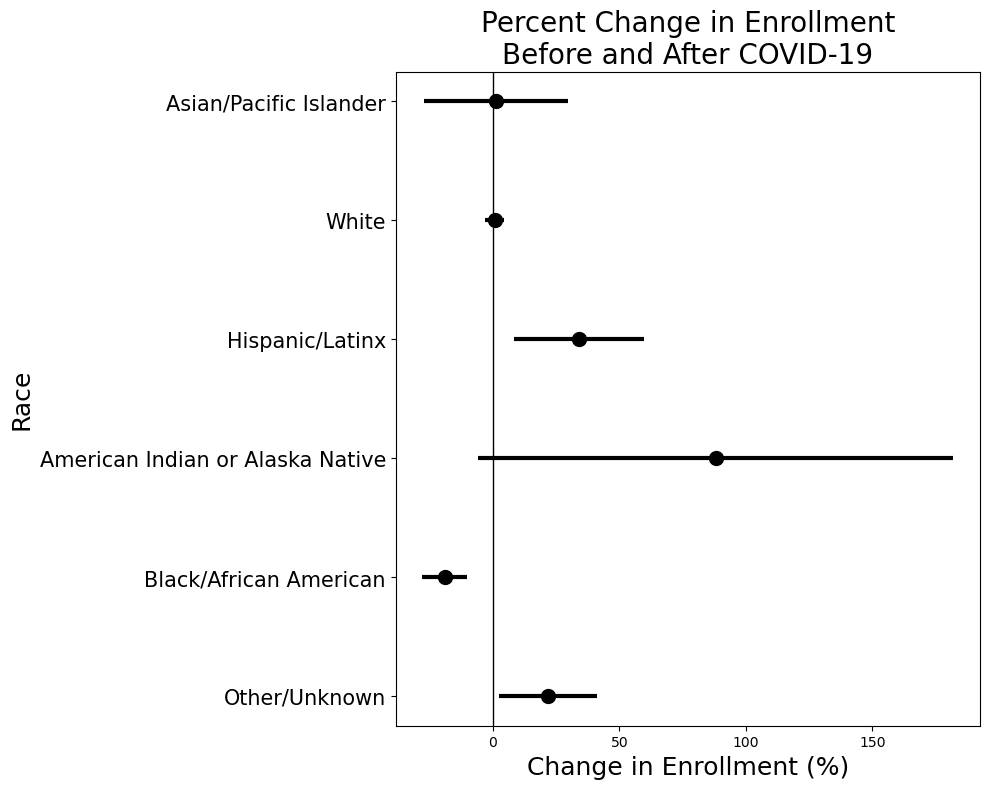

In [16]:
comparison_df = comparison_df.reindex(races)

comparison_df['Percentage Point Difference'] = (comparison_df['Before Pandemic (%)'] - comparison_df['After Pandemic (%)'])

comparison_df['Percent Change (%)'] = ((comparison_df['After Pandemic (%)'] - comparison_df['Before Pandemic (%)']) / comparison_df['Before Pandemic (%)']) * 100

comparison_df['Std Error Before'] = np.sqrt((comparison_df['Before Pandemic (%)'] * (100 - comparison_df['Before Pandemic (%)'])) / len(df_before_pandemic))
comparison_df['Std Error After'] = np.sqrt((comparison_df['After Pandemic (%)'] * (100 - comparison_df['After Pandemic (%)'])) / len(df_after_pandemic))

comparison_df['Std Error'] = (np.sqrt(comparison_df['Std Error Before']**2 + comparison_df['Std Error After']**2) / (comparison_df['Before Pandemic (%)'])) * 100

z_score = 1.96  # z-score for 95% confidence

comparison_df['95% CI Lower'] = comparison_df['Percent Change (%)'] - z_score * comparison_df['Std Error']
comparison_df['95% CI Upper'] = comparison_df['Percent Change (%)'] + z_score * comparison_df['Std Error']

t_statistic, p_value = ttest_rel(comparison_df['Before Pandemic (%)'], comparison_df['After Pandemic (%)'])


comparison_df['p-value'] = 2 * (1 - norm.cdf(np.abs(z_score)))


# Style Settings
line_width = 3
marker_size = 10
label_font_size = 18
title_font_size = 20
tick_font_size = 15

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(comparison_df['Percent Change (%)'], comparison_df.index, 'o', color='black', markersize=marker_size)

for i in range(len(comparison_df)):
    ax.hlines(y=i, xmin=comparison_df['95% CI Lower'].iloc[i], xmax=comparison_df['95% CI Upper'].iloc[i], 
              color='black', linewidth=line_width)  

ax.axvline(x=0, linestyle='-', color='black', linewidth=1)  # Solid line as in the second plot

ax.set_xlabel('Change in Enrollment (%)', fontsize=label_font_size)
ax.set_ylabel('Race', fontsize=label_font_size)
ax.set_title('Percent Change in Enrollment\nBefore and After COVID-19', fontsize=title_font_size)

ax.set_yticks(range(len(comparison_df.index)))
ax.set_yticklabels(comparison_df.index, fontsize=tick_font_size)

ax.invert_yaxis() 

plt.tight_layout()

plt.savefig('../output/change_in_enrollment_by_race.png')

plt.show()

In [17]:
# this table is for our LaTeX paper to help quantify our results
new_comparison_df = comparison_df[['Before Pandemic (%)', 'After Pandemic (%)', 'Percent Change (%)','Percentage Point Difference']]
new_comparison_df

,Before Pandemic (%),After Pandemic (%),Percent Change (%),Percentage Point Difference
race_clean,,,,
Asian/Pacific Islander,3.059672,3.098927,1.282988,-0.039255
White,62.737364,63.170441,0.690301,-0.433077
Hispanic/Latinx,4.671212,6.257449,33.957724,-1.586237
American Indian or Alaska Native,0.507128,0.953516,88.022778,-0.446388
Black/African American,21.637460,17.520858,-19.025346,4.116602
Other/Unknown,7.387164,8.998808,21.816817,-1.611644


In [18]:
new_comparison_df.to_excel('../output/enrollment_change.xlsx', index=False)